In [27]:
# Keras-based Fine-tuning ResNet-50 for Pneumonia Detection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



In [5]:

#step1 load data
data = np.load('pneumoniamnist.npz')

data

# Train data
x_train = data['train_images']
y_train = data['train_labels']

# Validation data
x_val = data['val_images']
y_val = data['val_labels']

# Test data
x_test = data['test_images']
y_test = data['test_labels']

In [6]:
# Check shapes
print("Train:", x_train.shape, y_train.shape)
print("Val:", x_val.shape, y_val.shape)
print("Test:", x_test.shape, y_test.shape)

Train: (3882, 28, 28) (3882, 1)
Val: (524, 28, 28) (524, 1)
Test: (624, 28, 28) (624, 1)


In [7]:
# check the shape and number of classes
print("Training data shape:", x_train.shape)
print("Validation data shape:", x_val.shape)
print("Test data shape:", x_test.shape)
print("Unique classes in y_train:", np.unique(y_train, return_counts=True))

Training data shape: (3882, 28, 28)
Validation data shape: (524, 28, 28)
Test data shape: (624, 28, 28)
Unique classes in y_train: (array([0, 1], dtype=uint8), array([ 388, 3494], dtype=int64))


In [8]:
# Step 3: Preprocess images for ResNet-50
#ResNet-50 expects 3-channel RGB images of size 224×224:

from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize


In [9]:
# Reshape and normalize (expand dims to add channel, convert grayscale to RGB)
def preprocess(images):
    images = np.expand_dims(images, axis=-1)  # (H, W) → (H, W, 1)
    images = np.repeat(images, 3, axis=-1)     # (H, W, 1) → (H, W, 3)
    images = tf.image.resize(images, [224, 224]) / 255.0  # Normalize to [0, 1]
    return images

x_train = preprocess(x_train)
x_val = preprocess(x_val)
x_test = preprocess(x_test)

In [10]:
# Convert labels to categorical (if needed for softmax)
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

In [11]:
#Step 4: Build and Fine-tune ResNet-50 Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


In [12]:
# Load base model (exclude top, use weights from ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [13]:
# Freeze base model initially
base_model.trainable = False

In [14]:
# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

In [15]:
# Final model
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
#Step 5: Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [18]:
#Step 6: Train the model
#Include early stopping and model checkpoint to avoid overfitting.
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('resnet50_pneumonia.keras', save_best_only=True)
]

history = model.fit(
    x_train, y_train_cat,
    validation_data=(x_val, y_val_cat),
    epochs=5,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.8209 - loss: 0.4857 - val_accuracy: 0.7424 - val_loss: 0.6917
Epoch 2/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.8986 - loss: 0.3650 - val_accuracy: 0.7424 - val_loss: 0.6394
Epoch 3/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.8964 - loss: 0.3637 - val_accuracy: 0.7424 - val_loss: 0.6511
Epoch 4/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8966 - loss: 0.3496 - val_accuracy: 0.7424 - val_loss: 0.6075
Epoch 5/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.8994 - loss: 0.3539 - val_accuracy: 0.7424 - val_loss: 0.5925


In [19]:
# Step 7: Evaluate the model
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test_cat)
print(f"Test Accuracy: {test_accuracy:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 791ms/step - accuracy: 0.6135 - loss: 0.7938
Test Accuracy: 0.6250


In [20]:
#1. Evaluation Using 3 Metrics
#We’ll use:
#Accuracy: Overall correctness.
#AUC (Area Under ROC Curve): Good for imbalanced classification.
#F1-Score : Balances precision and recall (important for medical diagnosis).
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
# Predict classes
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)



20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 844ms/step


In [21]:
# Accuracy, Precision, Recall, F1
print(classification_report(y_true, y_pred_classes, target_names=["Normal", "Pneumonia"]))

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       234
   Pneumonia       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



C:\Users\Rahul Sahu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Rahul Sahu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Rahul Sahu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# AUC Score
auc = roc_auc_score(y_test_cat, y_pred_probs)
print(f"AUC Score: {auc:.4f}")


AUC Score: 0.5819


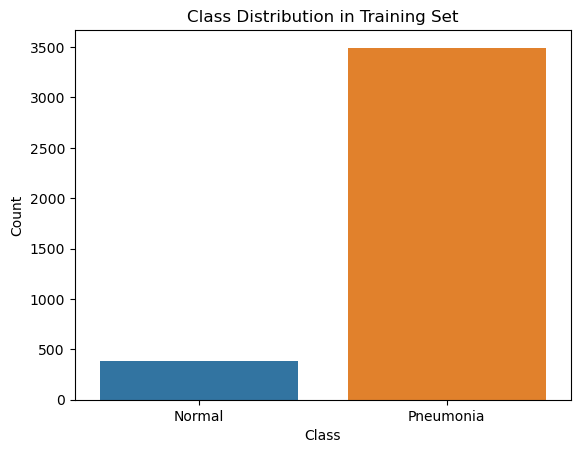

In [31]:
#2. Handle Class Imbalance
#First, analyze the imbalance:
class_counts = np.unique(y_train, return_counts=True)
sns.barplot(x=class_counts[0], y=class_counts[1])
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ["Normal", "Pneumonia"])
plt.show()


In [33]:
#Two ways to mitigate imbalance:
#Option A: Use Class Weights
#convert 2d array to 1D array
y_train_flat = y_train.ravel()
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_flat), y=y_train_flat)
class_weights_dict = dict(enumerate(class_weights))


In [36]:
# Pass to fit()
model.fit(
    x_train, y_train_cat,
    validation_data=(x_val, y_val_cat),
    epochs=5,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.4795 - loss: 0.7214 - val_accuracy: 0.2576 - val_loss: 0.7450
Epoch 2/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.5172 - loss: 0.7394 - val_accuracy: 0.2576 - val_loss: 0.7364
Epoch 3/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 119s 973ms/step - accuracy: 0.5594 - loss: 0.6904 - val_accuracy: 0.2576 - val_loss: 0.7461
Epoch 4/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.4674 - loss: 0.7446 - val_accuracy: 0.2576 - val_loss: 0.7275
Epoch 5/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.4513 - loss: 0.7395 - val_accuracy: 0.2576 - val_loss: 0.7118


In [37]:
#3. Prevent Overfitting
#We already added:
#Dropout layers in the model.
#EarlyStopping and ModelCheckpoint.
#Add Data Augmentation:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [38]:
# Re-train using the generator and class_weight
train_generator = datagen.flow(x_train, y_train_cat, batch_size=32)

model.fit(
    train_generator,
    validation_data=(x_val, y_val_cat),
    epochs=5,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/5


C:\Users\Rahul Sahu\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 1014s 8s/step - accuracy: 0.5138 - loss: 0.7328 - val_accuracy: 0.2576 - val_loss: 0.7445
Epoch 2/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 463s 4s/step - accuracy: 0.5284 - loss: 0.7245 - val_accuracy: 0.2576 - val_loss: 0.7629
Epoch 3/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 445s 4s/step - accuracy: 0.5327 - loss: 0.7089 - val_accuracy: 0.2576 - val_loss: 0.7525
Epoch 4/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 446s 4s/step - accuracy: 0.5499 - loss: 0.6798 - val_accuracy: 0.2576 - val_loss: 0.7606
Epoch 5/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 1195s 10s/step - accuracy: 0.3980 - loss: 0.7453 - val_accuracy: 0.2576 - val_loss: 0.7054


In [39]:
# Step 7: Evaluate the model
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test_cat)
print(f"Test Accuracy: {test_accuracy:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.3865 - loss: 0.7188
Test Accuracy: 0.3750


In [41]:
# Accuracy, Precision, Recall, F1
print(classification_report(y_true, y_pred_classes, target_names=["Normal", "Pneumonia"]))

              precision    recall  f1-score   support

      Normal       0.38      1.00      0.55       234
   Pneumonia       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



C:\Users\Rahul Sahu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Rahul Sahu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Rahul Sahu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
#1. Evaluation Using 3 Metrics
#We’ll use:
#Accuracy: Overall correctness.
#AUC (Area Under ROC Curve): Good for imbalanced classification.
#F1-Score : Balances precision and recall (important for medical diagnosis).
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
# Predict classes
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step


In [43]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

[[234   0]
 [390   0]]


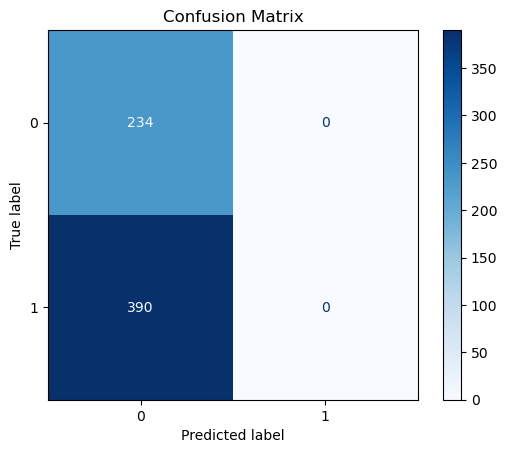

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [46]:
print("Unique classes in y_train:", np.unique(y_test, return_counts=True))
print("Unique classes in y_train:", np.unique(y_pred_classes, return_counts=True))

Unique classes in y_train: (array([0, 1], dtype=uint8), array([234, 390], dtype=int64))
Unique classes in y_train: (array([0], dtype=int64), array([624], dtype=int64))


In [42]:
# AUC Score
auc = roc_auc_score(y_test_cat, y_pred_probs)
print(f"AUC Score: {auc:.4f}")

AUC Score: 0.8710
